In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms 
from torchvision.utils import make_grid
import os 
import neurokit2 as nk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
from tqdm.notebook import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## Datasets and DataLoaders
Since the PyTorch DataLoader class constructs batches from a Dataset object, a custom ScalogramDataset class is created here. The ScalogramDataset() class has the following arguments
1. annotation_file : the 'REFERENCE.csv' file which contains the record number and diagnosis category for each signal
2. img_dir : the image directory
3. split_index : an array containing indices for train test split since such a split was not done at a directory level
4. transform : transformations on the images

In [11]:
training_img_dir = './../signal_cwt_images_training/'
label_list = pd.read_csv(training_img_dir + 'REFERENCE.csv', index_col=[0])

idx = np.arange(0, 8528)
idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle=True, random_state=100) # random_state=100 for reproducibility

In [3]:
class ScalogramDataset(Dataset):
    ''' 
    The scalogram dataset is initialized with the REFERENCE.csv file, image directory and a list of 
    suitable transformations on the image dataset.

    In this form, the annotations_file is represented as a directory reference to the REFERENCE.csv file. The split index argument refers to
    the particular train/test split inside the image directory.
    '''
    def __init__(self, annotations_file, img_dir, split_index, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=[0]).iloc[split_index, :]
        self.img_dir = img_dir 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)[0:3, :, :].float() # by default, the image tensors are uint8; these are converted to floats
        label = self.img_labels.iloc[idx, 2] # the third column contains the encoded diagnoses

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label 

During data augmentation, a major transformation is *normalization* where each pixel in each channel is transformed via
$$ \widetilde{\rm{pixel}}_{\rm{R,G,B}} = \frac{\rm{pixel}_{\rm{R,G,B}} - \mu_{\rm{R,G,B}}}{\sigma_{\rm{R,G,B}}} $$
where $\mu_{\rm{R,G,B}}$ and $\sigma_{\rm{R,G,B}}$ are the means and standard deviations of the pixels in the R, G, B channels. This can be calculated through the pixel_stats() function. This yields
$$ \mu_{\rm{R,G,B}}=\left[ 7.23, 26.71, 162.45 \right] $$
and, 
$$ \sigma_{\rm{R,G,B}}=\left[ 35.71, 66.20, 54.35 \right] $$
The large value of $\mu_{\rm{B}}$ is unsurprising due to the color map chosen to represent the scalograms.

In [ ]:
def pixel_stats(annotations_file, img_dir):
    img_labels = annotations_file.iloc[:,0] # dataframe converted into a series object here

    channel_sum = 0
    channel_squared_sum = 0

    for idx in range(len(img_labels)):
        img_file_name = img_labels[idx] + '.png'
        img_path = os.path.join(img_dir, img_file_name)
        img = read_image(img_path)[0:3, :, :].float()

        ''' 
        When the mean and standard deviation of the channels are calculated, the image matrix must be
        converted to the appropriate type using .float(). Otherwise, PyTorch will return an error message.
        '''
        channel_sum += torch.mean(img.float(), dim=[1, 2]) # dim=1,2 refer to the pixel axes only; returns a 1 x 3 tensor
        channel_squared_sum += torch.mean((img**2).float(), dim=[1,2])

    mean = channel_sum/len(img_labels)
    std = torch.sqrt(( channel_squared_sum/len(img_labels) - mean**2 ))

    return mean, std 

pixel_stats(label_list, training_img_dir)

For training, a batch sizes of $16,32$ and $64$ were used. For image augmentation, random crop, rotation and flipping are performed only on the training dataset. On both training and validation sets, however, the pixel normalization is performed. Moreover, they are resized to $3\times227\times227$ for training with AlexNet.

In [22]:
batch_size = 16

img_stats = ((7.2307,  26.7144, 162.4496), (35.7087, 66.2034, 54.3562))
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.RandomCrop(size=(227, 227), padding=4, padding_mode='reflect'),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

train_ds = ScalogramDataset(
    training_img_dir + 'REFERENCE.csv',
    training_img_dir,
    idx_train,
    transform=train_transform
)

valid_ds = ScalogramDataset(
    training_img_dir + 'REFERENCE.csv',
    training_img_dir,
    idx_test,
    transform=valid_transform
)

print(f'Size of the train set {len(train_ds)}.')
print(f'Size of the test dataset is {len(valid_ds)}.')

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

Size of the train set 6822.
Size of the test dataset is 1706.


In [ ]:
def show_batch(dataloader):
    for image, _ in dataloader:
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16, normalize=True).permute(1, 2, 0))
        break

print('Sample images from training set ')
show_batch(train_dl)
print('\n')
print('Sample images from validation set ')
show_batch(valid_dl)

## AlexNet

AlexNet is a CNN architecture that was designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton as part of the $2012$ ImageNet challenge. The AlexNet architecture is shown below, where there is a sequence of five convolutional layers followed by three fully-connected linear layers. The input image is of the form $(3\times227\times227)$. Each convolutional layer has a BatchNorm layer. Moreover, the linear layers have Dropout layers with $p=0.5$. The BatchNorm and Dropout layers are there two minimize overfitting during training.
 
<img src='.\images\alexnet.png' class='center' width='600' height='400'>

All in all, the AlexNet architecture has approximately $60$ million learnable parameters. Hence, training on very large datasets becomes impractical without GPU acceleration. However, the ECG dataset in question is not very large. Nevertheless, training for $150$ epochs on this current CPU (without GPU and other parallelization) takes approximately $6$ hours. A PyTorch class for the AlexNet architecture is shown below where the initial image of shape $\mathcal{B}\times3\times227\times 227$ (where $\mathcal{B}$ is the batch size) is processed through the layers until an output of shape $\mathcal{B}\times 4$ is produced, where $4$ being the number of classes present.

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Five convolutional layers

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),          # output shape : 96 x 55 x 55
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 96 x 27 x 27
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),         # output shape : 256 x 27 x 27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 13 x 13
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),        # output shape : 256 x 13 x 13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 6 x 6
        )

        # Three fully connected layers; starting input shape is 256 x 6 x 6 = 9216

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(-1, 9216)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [6]:
model = AlexNet()

Training is performed over $150$ epochs with a learning rate scheduler. The ADAM optimizer is used with default parameters with $\eta_{\rm{max}}=10^{-3}$ and weight decay of $10^{-4}$ and the cross-entropy loss is used on this multiclass dataset.

In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
   
def fit_one_cycle(num_epochs, max_lr, model, train_dl, valid_dl, loss_fn, opt_fun, weight_decay=0):
    '''
    Defining one complete cycle of training and validation over the specified number of epochs
    The function takes in the following parameters
    (1) number of epochs - num_epochs
    (2) maximum learning rate - max_lr
    (3) neural network model
    (4) training and validation/test dataloaders
    (5) regularization in terms of weigh decay (default set to 0)

    '''

    # instantiate optimizer with appropriate weight_decay
    optimizer = opt_fun(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_dl)
    )
    train_size = len(train_dl.dataset)
    valid_size = len(valid_dl.dataset)
    loss_train = [] # Loss history per epoch during training
    acc_train  = [] # Accuracy history per epoch during training
    loss_valid = [] # Loss history per epoch during validation
    acc_valid  = [] # Accuracy history per epoch during validation

    keys = ['epoch', 'training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy', 'last_lr']
    history = {key : [] for key in keys}    # initialize empty dictionary to store training and validation information and save as csv file 

    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        lrs = [] # for storing the adaptive learning rates per epoch

        for image, label in tqdm(train_dl, desc='Training loop'):
            
            '''  
            Calculate prediction and loss function per epoch
            '''
            output = model(image)
            loss = loss_fn(output, label)
            ''' 
            Backpropagating the loss function to re-adjust weights
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            '''
            Recording and updating learning rates
            '''
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()*image.size(0) # Accumulated loss per training batch
            _, predicted = torch.max(output, dim=1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

        training_loss = running_loss/train_size
        loss_train.append(training_loss)
        training_accuracy = running_correct/running_total # Proportion of accurate predictions 
        acc_train.append(training_accuracy)
        '''
        Validation phase
        '''
        running_loss = 0.0
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0

        with torch.no_grad():
            for image, label in tqdm(valid_dl, desc='Validation loop'):
                model.eval()
                output = model(image)
                loss = loss_fn(output, label)
                
                running_loss += loss.item()*image.size(0) # Accumulated loss per validation batch
                _, predicted = torch.max(output, dim=1)
                running_total += label.size(0)
                running_correct += (predicted == label).sum().item()
        validation_loss = running_loss/valid_size 
        loss_valid.append(validation_loss)
        validation_accuracy = running_correct/running_total
        acc_valid.append(validation_accuracy)

        # Append information in csv file
        history['epoch'].append(epoch)
        history['training_accuracy'].append(training_accuracy)
        history['training_loss'].append(training_loss)
        history['validation_accuracy'].append(validation_accuracy)
        history['validation_loss'].append(validation_loss)
        history['last_lr'].append(lrs[-1])

        # Epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}: trainining loss = {training_loss:4f}, last_lr = {lrs[-1]}, training accuracy = {training_accuracy:4f},\
               validation loss = {validation_loss:4f}, validation accuracy = {validation_accuracy:4f}')
        
    history_df = pd.DataFrame.from_dict(history)
    history_df.to_csv('./../training_histories/history.csv')
    
    return loss_train, acc_train, loss_valid, acc_valid

In [8]:
num_epochs = 150
max_lr = 0.001
weight_decay = 0.0001
opt_fun = torch.optim.Adam

loss_fn = nn.CrossEntropyLoss()

loss_train, acc_train, loss_valid, acc_valid = fit_one_cycle(
    num_epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt_fun,
    weight_decay=weight_decay
)

Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1/150: trainining loss = 1.024639, last_lr = 4.1163908985147445e-05, training accuracy = 0.570067,               validation loss = 0.966784, validation accuracy = 0.584408


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2/150: trainining loss = 0.958025, last_lr = 4.4660895592033554e-05, training accuracy = 0.598358,               validation loss = 0.904761, validation accuracy = 0.600821


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3/150: trainining loss = 0.913134, last_lr = 5.047392749687183e-05, training accuracy = 0.609645,               validation loss = 0.885092, validation accuracy = 0.610785


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4/150: trainining loss = 0.888454, last_lr = 5.8574681245763724e-05, training accuracy = 0.618001,               validation loss = 0.846455, validation accuracy = 0.635404


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5/150: trainining loss = 0.848682, last_lr = 6.89236866742392e-05, training accuracy = 0.631047,               validation loss = 0.906878, validation accuracy = 0.638335


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 6/150: trainining loss = 0.846508, last_lr = 8.147051922193936e-05, training accuracy = 0.631633,               validation loss = 1.055173, validation accuracy = 0.493552


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 7/150: trainining loss = 0.840918, last_lr = 9.615404562156749e-05, training accuracy = 0.636910,               validation loss = 0.806917, validation accuracy = 0.641852


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 8/150: trainining loss = 0.840267, last_lr = 0.00011290272176501257, training accuracy = 0.633685,               validation loss = 0.815452, validation accuracy = 0.627784


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 9/150: trainining loss = 0.831758, last_lr = 0.00013163494129531984, training accuracy = 0.640575,               validation loss = 0.877503, validation accuracy = 0.628370


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 10/150: trainining loss = 0.835798, last_lr = 0.00015225943322602696, training accuracy = 0.639695,               validation loss = 0.832853, validation accuracy = 0.659437


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 11/150: trainining loss = 0.829668, last_lr = 0.00017467570665050363, training accuracy = 0.642187,               validation loss = 0.896950, validation accuracy = 0.621923


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 12/150: trainining loss = 0.822698, last_lr = 0.00019877454037448895, training accuracy = 0.646145,               validation loss = 0.939635, validation accuracy = 0.599062


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 13/150: trainining loss = 0.822807, last_lr = 0.0002244385150861379, training accuracy = 0.645705,               validation loss = 0.878973, validation accuracy = 0.635991


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 14/150: trainining loss = 0.821903, last_lr = 0.000251542585470629, training accuracy = 0.649809,               validation loss = 0.833943, validation accuracy = 0.636577


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 15/150: trainining loss = 0.814218, last_lr = 0.0002799546894817572, training accuracy = 0.646731,               validation loss = 0.892000, validation accuracy = 0.620164


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 16/150: trainining loss = 0.826160, last_lr = 0.0003095363918018942, training accuracy = 0.645412,               validation loss = 0.811626, validation accuracy = 0.652989


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 17/150: trainining loss = 0.827367, last_lr = 0.0003401435583551168, training accuracy = 0.647171,               validation loss = 0.849558, validation accuracy = 0.647128


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 18/150: trainining loss = 0.817459, last_lr = 0.00037162705858700214, training accuracy = 0.646145,               validation loss = 0.836782, validation accuracy = 0.654748


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 19/150: trainining loss = 0.814082, last_lr = 0.00040383349208929643, training accuracy = 0.649223,               validation loss = 0.965398, validation accuracy = 0.636577


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 20/150: trainining loss = 0.816073, last_lr = 0.0004366059360290473, training accuracy = 0.649077,               validation loss = 0.821308, validation accuracy = 0.642438


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 21/150: trainining loss = 0.817600, last_lr = 0.00046978470974041997, training accuracy = 0.649663,               validation loss = 0.781498, validation accuracy = 0.660610


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 22/150: trainining loss = 0.808286, last_lr = 0.0005032081527537973, training accuracy = 0.655233,               validation loss = 0.775739, validation accuracy = 0.665299


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 23/150: trainining loss = 0.826753, last_lr = 0.0005367134124712875, training accuracy = 0.645705,               validation loss = 0.825018, validation accuracy = 0.629543


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 24/150: trainining loss = 0.820426, last_lr = 0.0005701372376507647, training accuracy = 0.652155,               validation loss = 0.812001, validation accuracy = 0.628957


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 25/150: trainining loss = 0.817176, last_lr = 0.0006033167738322685, training accuracy = 0.655380,               validation loss = 1.078669, validation accuracy = 0.617233


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 26/150: trainining loss = 0.821253, last_lr = 0.0006360903568311174, training accuracy = 0.648637,               validation loss = 0.787861, validation accuracy = 0.657679


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 27/150: trainining loss = 0.825375, last_lr = 0.0006682983004315179, training accuracy = 0.648930,               validation loss = 0.919963, validation accuracy = 0.628370


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 28/150: trainining loss = 0.806843, last_lr = 0.0006997836744427059, training accuracy = 0.663442,               validation loss = 0.947392, validation accuracy = 0.635991


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 29/150: trainining loss = 0.819914, last_lr = 0.0007303930693266131, training accuracy = 0.657578,               validation loss = 1.018575, validation accuracy = 0.613130


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 30/150: trainining loss = 0.824608, last_lr = 0.0007599773436714845, training accuracy = 0.657432,               validation loss = 0.792988, validation accuracy = 0.675850


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 31/150: trainining loss = 0.824302, last_lr = 0.0007883923508694464, training accuracy = 0.659191,               validation loss = 0.833173, validation accuracy = 0.650059


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 32/150: trainining loss = 0.839418, last_lr = 0.0008154996414573648, training accuracy = 0.651715,               validation loss = 0.911050, validation accuracy = 0.639508


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 33/150: trainining loss = 0.833527, last_lr = 0.0008411671376988949, training accuracy = 0.652008,               validation loss = 0.778563, validation accuracy = 0.679367


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 34/150: trainining loss = 0.814937, last_lr = 0.00086526977712089, training accuracy = 0.653914,               validation loss = 0.845604, validation accuracy = 0.641266


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 35/150: trainining loss = 0.819618, last_lr = 0.0008876901218685981, training accuracy = 0.657725,               validation loss = 0.987175, validation accuracy = 0.651817


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 36/150: trainining loss = 0.807727, last_lr = 0.0009083189309106167, training accuracy = 0.661096,               validation loss = 0.849691, validation accuracy = 0.634818


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 37/150: trainining loss = 0.806768, last_lr = 0.000927055692305595, training accuracy = 0.660950,               validation loss = 0.806996, validation accuracy = 0.667644


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 38/150: trainining loss = 0.841134, last_lr = 0.0009438091129372599, training accuracy = 0.648197,               validation loss = 1.019568, validation accuracy = 0.616061


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 39/150: trainining loss = 0.815524, last_lr = 0.000958497563331582, training accuracy = 0.671357,               validation loss = 0.817731, validation accuracy = 0.662954


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 40/150: trainining loss = 0.798335, last_lr = 0.0009710494753887466, training accuracy = 0.665201,               validation loss = 0.870379, validation accuracy = 0.643025


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 41/150: trainining loss = 0.799698, last_lr = 0.0009814036910920229, training accuracy = 0.667546,               validation loss = 1.093141, validation accuracy = 0.622509


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 42/150: trainining loss = 0.799156, last_lr = 0.0009895097604944755, training accuracy = 0.662709,               validation loss = 0.794523, validation accuracy = 0.667644


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 43/150: trainining loss = 0.802160, last_lr = 0.00099532818753161, training accuracy = 0.665494,               validation loss = 0.842750, validation accuracy = 0.650059


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 44/150: trainining loss = 0.796967, last_lr = 0.0009988306224622506, training accuracy = 0.666813,               validation loss = 0.788178, validation accuracy = 0.664127


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 45/150: trainining loss = 0.782956, last_lr = 0.001, training accuracy = 0.671504,               validation loss = 0.809319, validation accuracy = 0.634818


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 46/150: trainining loss = 0.791583, last_lr = 0.0009997762170368871, training accuracy = 0.671944,               validation loss = 0.764714, validation accuracy = 0.682884


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 47/150: trainining loss = 0.784293, last_lr = 0.000999105068463608, training accuracy = 0.673703,               validation loss = 0.796447, validation accuracy = 0.661196


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 48/150: trainining loss = 0.788470, last_lr = 0.0009979871550490316, training accuracy = 0.668279,               validation loss = 0.801362, validation accuracy = 0.656506


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 49/150: trainining loss = 0.775599, last_lr = 0.000996423477477066, training accuracy = 0.682498,               validation loss = 0.730265, validation accuracy = 0.706331


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 50/150: trainining loss = 0.767721, last_lr = 0.0009944154354509117, training accuracy = 0.682205,               validation loss = 0.736416, validation accuracy = 0.697538


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 51/150: trainining loss = 0.766145, last_lr = 0.0009919648264401376, training accuracy = 0.684697,               validation loss = 0.761759, validation accuracy = 0.665885


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 52/150: trainining loss = 0.762537, last_lr = 0.0009890738440717015, training accuracy = 0.685723,               validation loss = 0.745181, validation accuracy = 0.677022


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 53/150: trainining loss = 0.764168, last_lr = 0.0009857450761663572, training accuracy = 0.688215,               validation loss = 0.758187, validation accuracy = 0.677608


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 54/150: trainining loss = 0.760207, last_lr = 0.0009819815024222052, training accuracy = 0.684403,               validation loss = 0.783966, validation accuracy = 0.673505


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 55/150: trainining loss = 0.751108, last_lr = 0.0009777864917474587, training accuracy = 0.687482,               validation loss = 0.825137, validation accuracy = 0.623681


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 56/150: trainining loss = 0.763797, last_lr = 0.0009731637992448144, training accuracy = 0.684257,               validation loss = 0.955302, validation accuracy = 0.566237


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 57/150: trainining loss = 0.746645, last_lr = 0.0009681175628501272, training accuracy = 0.695837,               validation loss = 0.765371, validation accuracy = 0.690504


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 58/150: trainining loss = 0.743460, last_lr = 0.0009626522996283973, training accuracy = 0.694811,               validation loss = 0.772961, validation accuracy = 0.684642


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 59/150: trainining loss = 0.747540, last_lr = 0.000956772901730385, training accuracy = 0.692759,               validation loss = 0.790378, validation accuracy = 0.688746


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 60/150: trainining loss = 0.744137, last_lr = 0.0009504846320134736, training accuracy = 0.693638,               validation loss = 0.749198, validation accuracy = 0.694021


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 61/150: trainining loss = 0.741874, last_lr = 0.000943793119330699, training accuracy = 0.695984,               validation loss = 0.731331, validation accuracy = 0.684642


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 62/150: trainining loss = 0.733371, last_lr = 0.0009367043534921636, training accuracy = 0.703459,               validation loss = 0.884287, validation accuracy = 0.661782


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 63/150: trainining loss = 0.741809, last_lr = 0.0009292246799033457, training accuracy = 0.694518,               validation loss = 0.782214, validation accuracy = 0.689332


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 64/150: trainining loss = 0.734051, last_lr = 0.0009213607938851022, training accuracy = 0.696863,               validation loss = 0.729223, validation accuracy = 0.674091


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 65/150: trainining loss = 0.723613, last_lr = 0.0009131197346804487, training accuracy = 0.703753,               validation loss = 0.729510, validation accuracy = 0.684642


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 66/150: trainining loss = 0.724955, last_lr = 0.0009045088791534849, training accuracy = 0.708883,               validation loss = 0.717231, validation accuracy = 0.702227


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 67/150: trainining loss = 0.715220, last_lr = 0.0008955359351861013, training accuracy = 0.710349,               validation loss = 0.712618, validation accuracy = 0.711606


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 68/150: trainining loss = 0.724814, last_lr = 0.0008862089347783812, training accuracy = 0.707417,               validation loss = 0.752561, validation accuracy = 0.716882


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 69/150: trainining loss = 0.714918, last_lr = 0.0008765362268588734, training accuracy = 0.704339,               validation loss = 0.770474, validation accuracy = 0.679953


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 70/150: trainining loss = 0.724574, last_lr = 0.0008665264698111694, training accuracy = 0.702726,               validation loss = 0.750174, validation accuracy = 0.697538


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 71/150: trainining loss = 0.711121, last_lr = 0.0008561886237234784, training accuracy = 0.715186,               validation loss = 0.728223, validation accuracy = 0.702227


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 72/150: trainining loss = 0.713985, last_lr = 0.0008455319423681343, training accuracy = 0.710202,               validation loss = 0.729204, validation accuracy = 0.693435


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 73/150: trainining loss = 0.710118, last_lr = 0.0008345659649182163, training accuracy = 0.713720,               validation loss = 0.825455, validation accuracy = 0.684642


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 74/150: trainining loss = 0.712985, last_lr = 0.0008233005074086972, training accuracy = 0.716212,               validation loss = 0.724328, validation accuracy = 0.696952


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 75/150: trainining loss = 0.708384, last_lr = 0.000811745653949763, training accuracy = 0.715773,               validation loss = 0.715103, validation accuracy = 0.705158


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 76/150: trainining loss = 0.699768, last_lr = 0.0007999117477001673, training accuracy = 0.713867,               validation loss = 1.480879, validation accuracy = 0.639508


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 77/150: trainining loss = 0.705404, last_lr = 0.0007878093816087053, training accuracy = 0.709616,               validation loss = 0.698768, validation accuracy = 0.718054


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 78/150: trainining loss = 0.705008, last_lr = 0.0007754493889320882, training accuracy = 0.712108,               validation loss = 0.730948, validation accuracy = 0.685229


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 79/150: trainining loss = 0.701202, last_lr = 0.0007628428335377126, training accuracy = 0.711961,               validation loss = 0.719333, validation accuracy = 0.713365


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 80/150: trainining loss = 0.701586, last_lr = 0.0007500009999999999, training accuracy = 0.715186,               validation loss = 0.745998, validation accuracy = 0.684642


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 81/150: trainining loss = 0.697983, last_lr = 0.0007369353834991743, training accuracy = 0.717238,               validation loss = 0.894245, validation accuracy = 0.682884


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 82/150: trainining loss = 0.696739, last_lr = 0.0007236576795315195, training accuracy = 0.725594,               validation loss = 0.941262, validation accuracy = 0.678781


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 83/150: trainining loss = 0.686865, last_lr = 0.0007101797734403261, training accuracy = 0.721050,               validation loss = 0.694149, validation accuracy = 0.719226


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 84/150: trainining loss = 0.684927, last_lr = 0.0006965137297768985, training accuracy = 0.718558,               validation loss = 0.758959, validation accuracy = 0.674091


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 85/150: trainining loss = 0.685763, last_lr = 0.0006826717815011488, training accuracy = 0.724128,               validation loss = 0.665822, validation accuracy = 0.729777


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 86/150: trainining loss = 0.685871, last_lr = 0.0006686663190314402, training accuracy = 0.722955,               validation loss = 0.689514, validation accuracy = 0.715709


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 87/150: trainining loss = 0.682194, last_lr = 0.0006545098791534849, training accuracy = 0.722076,               validation loss = 0.669046, validation accuracy = 0.724502


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 88/150: trainining loss = 0.674720, last_lr = 0.0006402151337982227, training accuracy = 0.728086,               validation loss = 0.663623, validation accuracy = 0.723329


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 89/150: trainining loss = 0.674860, last_lr = 0.0006257948786987268, training accuracy = 0.726766,               validation loss = 0.677726, validation accuracy = 0.721571


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 90/150: trainining loss = 0.673377, last_lr = 0.0006112620219362892, training accuracy = 0.726327,               validation loss = 0.656645, validation accuracy = 0.730950


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 91/150: trainining loss = 0.678159, last_lr = 0.0005966295723859409, training accuracy = 0.724861,               validation loss = 0.657085, validation accuracy = 0.734467


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 92/150: trainining loss = 0.661997, last_lr = 0.0005819106280717459, training accuracy = 0.726473,               validation loss = 0.649477, validation accuracy = 0.732708


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 93/150: trainining loss = 0.666719, last_lr = 0.000567118364442296, training accuracy = 0.728819,               validation loss = 0.641474, validation accuracy = 0.740328


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 94/150: trainining loss = 0.658684, last_lr = 0.0005522660225769001, training accuracy = 0.729551,               validation loss = 0.754148, validation accuracy = 0.697538


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 95/150: trainining loss = 0.662795, last_lr = 0.0005373668973330249, training accuracy = 0.725887,               validation loss = 0.629918, validation accuracy = 0.747362


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 96/150: trainining loss = 0.658886, last_lr = 0.0005224343254455967, training accuracy = 0.736734,               validation loss = 0.656276, validation accuracy = 0.731536


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 97/150: trainining loss = 0.657186, last_lr = 0.0005074816735888177, training accuracy = 0.732190,               validation loss = 0.652543, validation accuracy = 0.743845


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 98/150: trainining loss = 0.650768, last_lr = 0.0004925223264111823, training accuracy = 0.738933,               validation loss = 0.697448, validation accuracy = 0.712192


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 99/150: trainining loss = 0.654990, last_lr = 0.0004775696745544034, training accuracy = 0.736588,               validation loss = 0.649296, validation accuracy = 0.740914


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 100/150: trainining loss = 0.651213, last_lr = 0.00046263710266697503, training accuracy = 0.735855,               validation loss = 0.646546, validation accuracy = 0.735053


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 101/150: trainining loss = 0.654243, last_lr = 0.0004477379774230999, training accuracy = 0.737467,               validation loss = 0.658150, validation accuracy = 0.727433


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 102/150: trainining loss = 0.641611, last_lr = 0.00043288563555770405, training accuracy = 0.737760,               validation loss = 0.657377, validation accuracy = 0.736225


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 103/150: trainining loss = 0.645612, last_lr = 0.00041809337192825395, training accuracy = 0.738347,               validation loss = 0.699533, validation accuracy = 0.709848


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 104/150: trainining loss = 0.645203, last_lr = 0.00040337442761405903, training accuracy = 0.740692,               validation loss = 0.638898, validation accuracy = 0.739156


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 105/150: trainining loss = 0.635762, last_lr = 0.00038874197806371076, training accuracy = 0.741865,               validation loss = 0.644829, validation accuracy = 0.743845


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 106/150: trainining loss = 0.641830, last_lr = 0.00037420912130127325, training accuracy = 0.743624,               validation loss = 0.642365, validation accuracy = 0.729777


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 107/150: trainining loss = 0.631101, last_lr = 0.0003597888662017773, training accuracy = 0.744210,               validation loss = 0.652695, validation accuracy = 0.735639


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 108/150: trainining loss = 0.630949, last_lr = 0.0003454941208465151, training accuracy = 0.745529,               validation loss = 0.633489, validation accuracy = 0.738570


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 109/150: trainining loss = 0.633395, last_lr = 0.00033133768096855977, training accuracy = 0.744063,               validation loss = 0.619430, validation accuracy = 0.748535


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 110/150: trainining loss = 0.632256, last_lr = 0.0003173322184988512, training accuracy = 0.742744,               validation loss = 0.617076, validation accuracy = 0.759672


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 111/150: trainining loss = 0.620925, last_lr = 0.00030349027022310155, training accuracy = 0.750220,               validation loss = 0.635405, validation accuracy = 0.737397


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 112/150: trainining loss = 0.619418, last_lr = 0.00028982422655967396, training accuracy = 0.751246,               validation loss = 0.638905, validation accuracy = 0.737397


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 113/150: trainining loss = 0.614513, last_lr = 0.00027634632046848027, training accuracy = 0.756523,               validation loss = 0.623263, validation accuracy = 0.749121


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 114/150: trainining loss = 0.616449, last_lr = 0.00026306861650082563, training accuracy = 0.749047,               validation loss = 0.611310, validation accuracy = 0.747948


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 115/150: trainining loss = 0.612049, last_lr = 0.0002500030000000001, training accuracy = 0.753005,               validation loss = 0.641953, validation accuracy = 0.743259


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 116/150: trainining loss = 0.615257, last_lr = 0.00023716116646228723, training accuracy = 0.755644,               validation loss = 0.631123, validation accuracy = 0.736225


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 117/150: trainining loss = 0.599290, last_lr = 0.0002245546110679117, training accuracy = 0.760041,               validation loss = 0.612795, validation accuracy = 0.754982


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 118/150: trainining loss = 0.602945, last_lr = 0.00021219461839129468, training accuracy = 0.759894,               validation loss = 0.618939, validation accuracy = 0.750293


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 119/150: trainining loss = 0.606425, last_lr = 0.00020009225229983247, training accuracy = 0.759601,               validation loss = 0.619542, validation accuracy = 0.750293


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 120/150: trainining loss = 0.605683, last_lr = 0.00018825834605023698, training accuracy = 0.760334,               validation loss = 0.604313, validation accuracy = 0.766120


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 121/150: trainining loss = 0.596377, last_lr = 0.0001767034925913027, training accuracy = 0.757989,               validation loss = 0.595753, validation accuracy = 0.763189


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 122/150: trainining loss = 0.592449, last_lr = 0.00016543803508178376, training accuracy = 0.766051,               validation loss = 0.616008, validation accuracy = 0.749707


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 123/150: trainining loss = 0.594843, last_lr = 0.00015447205763186565, training accuracy = 0.762973,               validation loss = 0.601505, validation accuracy = 0.757913


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 124/150: trainining loss = 0.585544, last_lr = 0.0001438153762765216, training accuracy = 0.765611,               validation loss = 0.603515, validation accuracy = 0.756155


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 125/150: trainining loss = 0.589659, last_lr = 0.00013347753018883065, training accuracy = 0.761214,               validation loss = 0.586065, validation accuracy = 0.767878


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 126/150: trainining loss = 0.585320, last_lr = 0.00012346777314112658, training accuracy = 0.767957,               validation loss = 0.599346, validation accuracy = 0.752052


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 127/150: trainining loss = 0.582549, last_lr = 0.00011379506522161879, training accuracy = 0.767077,               validation loss = 0.601272, validation accuracy = 0.751465


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 128/150: trainining loss = 0.586859, last_lr = 0.00010446806481389881, training accuracy = 0.762973,               validation loss = 0.590830, validation accuracy = 0.756155


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 129/150: trainining loss = 0.577351, last_lr = 9.549512084651507e-05, training accuracy = 0.768396,               validation loss = 0.594791, validation accuracy = 0.753224


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 130/150: trainining loss = 0.577413, last_lr = 8.688426531955123e-05, training accuracy = 0.771328,               validation loss = 0.592054, validation accuracy = 0.756741


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 131/150: trainining loss = 0.574675, last_lr = 7.864320611489772e-05, training accuracy = 0.767810,               validation loss = 0.589450, validation accuracy = 0.754982


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 132/150: trainining loss = 0.584283, last_lr = 7.077932009665415e-05, training accuracy = 0.764585,               validation loss = 0.593211, validation accuracy = 0.759086


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 133/150: trainining loss = 0.577939, last_lr = 6.32996465078364e-05, training accuracy = 0.773087,               validation loss = 0.601254, validation accuracy = 0.752052


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 134/150: trainining loss = 0.576555, last_lr = 5.6210880669300965e-05, training accuracy = 0.769862,               validation loss = 0.595151, validation accuracy = 0.763189


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 135/150: trainining loss = 0.570919, last_lr = 4.9519367986526286e-05, training accuracy = 0.774553,               validation loss = 0.591509, validation accuracy = 0.757913


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 136/150: trainining loss = 0.575736, last_lr = 4.3231098269614797e-05, training accuracy = 0.769716,               validation loss = 0.584569, validation accuracy = 0.764947


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 137/150: trainining loss = 0.570654, last_lr = 3.73517003716026e-05, training accuracy = 0.777631,               validation loss = 0.589595, validation accuracy = 0.759086


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 138/150: trainining loss = 0.574207, last_lr = 3.1886437149872676e-05, training accuracy = 0.774553,               validation loss = 0.589472, validation accuracy = 0.757327


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 139/150: trainining loss = 0.565280, last_lr = 2.6840200755185466e-05, training accuracy = 0.776165,               validation loss = 0.588109, validation accuracy = 0.758499


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 140/150: trainining loss = 0.569181, last_lr = 2.2217508252541176e-05, training accuracy = 0.778950,               validation loss = 0.584516, validation accuracy = 0.766706


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 141/150: trainining loss = 0.565268, last_lr = 1.8022497577794767e-05, training accuracy = 0.774846,               validation loss = 0.591707, validation accuracy = 0.759672


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 142/150: trainining loss = 0.565177, last_lr = 1.4258923833642831e-05, training accuracy = 0.774406,               validation loss = 0.587859, validation accuracy = 0.759672


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 143/150: trainining loss = 0.565030, last_lr = 1.0930155928298623e-05, training accuracy = 0.774700,               validation loss = 0.585325, validation accuracy = 0.762016


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 144/150: trainining loss = 0.560092, last_lr = 8.039173559862363e-06, training accuracy = 0.779244,               validation loss = 0.587504, validation accuracy = 0.763189


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 145/150: trainining loss = 0.556552, last_lr = 5.588564549088189e-06, training accuracy = 0.779537,               validation loss = 0.585173, validation accuracy = 0.768464


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 146/150: trainining loss = 0.562320, last_lr = 3.580522522934006e-06, training accuracy = 0.775872,               validation loss = 0.586446, validation accuracy = 0.764361


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 147/150: trainining loss = 0.560400, last_lr = 2.016844950968456e-06, training accuracy = 0.773234,               validation loss = 0.587194, validation accuracy = 0.765533


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 148/150: trainining loss = 0.564202, last_lr = 8.989315363919581e-07, training accuracy = 0.779244,               validation loss = 0.585628, validation accuracy = 0.757913


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 149/150: trainining loss = 0.563560, last_lr = 2.277829631129057e-07, training accuracy = 0.779683,               validation loss = 0.587063, validation accuracy = 0.764361


Training loop:   0%|          | 0/427 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 150/150: trainining loss = 0.562353, last_lr = 4e-09, training accuracy = 0.779683,               validation loss = 0.582981, validation accuracy = 0.763189


Over $150$ epochs, it can be seen that AlexNet performs relatively well, with the prediction accuracy saturating to $\sim 76\%$ for $\mathcal{B}=16$ with no signs of overfitting (so far). However, we notice that the validation loss and accuracy curves display a lot of variation epoch-to-epoch, at least until epoch $125$. This maybe attributed to the inherent class imbalance in the dataset.

In [9]:
# Saving model

#torch.save(model.state_dict(), './../saved/afibclass_adamoptim_alexnet_batchsize16.pth')

However, the accuracy score is not always the best predictor of performance for classification tasks. Hence, it is important to assess other metrics such as precision, recall and the $F_1$ scores of the different classes. First, the confusion matrix is calculated and plotted as a heatmap.

In [12]:
@torch.no_grad()
def get_confusion_matrix(valid_dl, model):
    # Defining a function for calculating the confusion matrix
    # Require the total number of true and prediction labels in each category

    all_preds = torch.Tensor([])

    for image, label in valid_dl:

        output = model(image)

        all_preds = torch.cat((all_preds, output.data), dim=0) # vertically stacks all outputs from iterations

    '''
    Converting the PyTorch tensors into numpy arrays
    '''
    all_preds = torch.max(all_preds, dim=1).indices.numpy()
    all_labels = label_list.iloc[idx_test, 2].to_numpy()
    
    return confusion_matrix(all_labels, all_preds)

CM = get_confusion_matrix(valid_dl, model)

print(CM)

[[ 73  33  32   7]
 [  9 928  50  10]
 [ 33 201 260  13]
 [  2   9   5  41]]


Since the train/test split was not stratified, it can be seen that the validation set is over represented by normal rhythm examples, on which it performs very well. Interestingly, a significant number of 'Normal' rhythms are classified as 'Other/Unclassified', which might arise from inherent similarities between them.

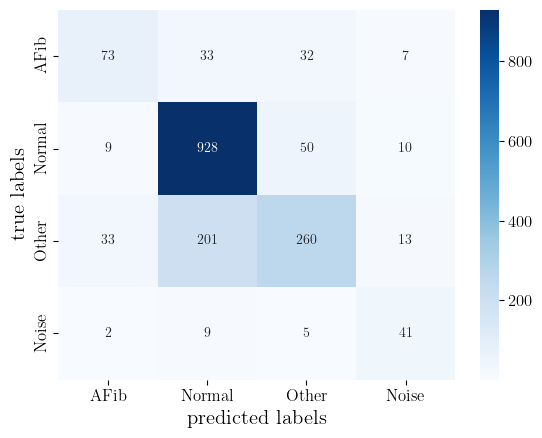

In [15]:
class_labels = ['AFib', 'Normal', 'Other', 'Noise']

sns.heatmap(CM, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel(r'predicted labels', fontsize=15)
plt.ylabel(r'true labels', fontsize=15)
#plt.savefig('./../results/CM_adam_optim_alexnet_batchsize16.png', dpi=300, bbox_inches='tight')
plt.show()

For a multiclass dataset, the precision and recall values can be best calculated using the confusion matrix. In a confusion matrix, the $y$-axis represents the true labels while the $x$ represents the predictions. Let $C_{ij}$ represent the elements of the confusion matrix. Then
$$ \text{Precision}_i = \frac{C_{ii}}{\sum_{i} C_{ij}},\;\;\;\;\; \text{Recall}_i = \frac{C_{ii}}{\sum_{j}C_{ij}} $$
where $i$ is the class label.

In [16]:
def F1_score(CM, class_label):
    '''
    This function returns the F1 score associated with a particular class label.
    0 - AFib, 1 - Normal, 2 - Other, 3 - Noise
    '''
    keys = {
        'AFib'   : 0,
        'Normal' : 1,
        'Other'  : 2,
        'Noise'  : 3
    }
    key = keys[class_label]

    precision = CM[key, key] / CM[:, key].sum()
    recall = CM[key, key] / CM[key, :].sum()
    F1_score = 2*precision*recall / (precision + recall)

    return F1_score 

F1_AFib = F1_score(CM, 'AFib')
F1_Normal = F1_score(CM, 'Normal')
F1_Other = F1_score(CM, 'Other')
F1_Noise = F1_score(CM, 'Noise')
F1_overall = 0.25*(F1_AFib + F1_Normal + F1_Other + F1_Noise)
accuracy_score = np.trace(CM)/np.sum(CM)

print(f'F1 score for AFib: {F1_AFib}')
print(f'F1 score for Normal: {F1_Normal}')
print(f'F1 score for Other: {F1_Other}')
print(f'F1 score for Noise: {F1_Noise}')

print(f'Overall F1 score: {F1_overall}')
print(f'Accuracy score: {accuracy_score}')

F1 score for AFib: 0.5572519083969466
F1 score for Normal: 0.856088560885609
F1 score for Other: 0.6088992974238876
F1 score for Noise: 0.6406249999999999
Overall F1 score: 0.6657161916766108
Accuracy score: 0.7631887456037515
